# Semantic Segmentation

## Dataset
The project use [this dataset](https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip) to carry out semantic segmentation. Please download an extract it to dataset folder under the root path of the project before moving on.

In [1]:
from keras.applications.vgg16 import VGG16 as PTModel
import glob, os
import cv2
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# initialize paths to the datasets
base_dir = "dataset/"
seg_dir = base_dir + "/annotations_prepped_train/"
img_dir = base_dir +"/images_prepped_train/"

In [3]:
all_img_paths = glob.glob(os.path.join(img_dir + "*.png"))
all_img_paths[:5]

['dataset//images_prepped_train\\0001TP_006690.png',
 'dataset//images_prepped_train\\0001TP_006720.png',
 'dataset//images_prepped_train\\0001TP_006750.png',
 'dataset//images_prepped_train\\0001TP_006780.png',
 'dataset//images_prepped_train\\0001TP_006810.png']

In [4]:
all_mask_paths = glob.glob(os.path.join(seg_dir, '*.png'))
all_mask_paths[:5]

['dataset//annotations_prepped_train\\0001TP_006690.png',
 'dataset//annotations_prepped_train\\0001TP_006720.png',
 'dataset//annotations_prepped_train\\0001TP_006750.png',
 'dataset//annotations_prepped_train\\0001TP_006780.png',
 'dataset//annotations_prepped_train\\0001TP_006810.png']

In [5]:
all_img_paths[0].split('\\')[-1]

'0001TP_006690.png'

In [6]:
# initialize list of images and their corresponding masks
imgs = []
imgs_mask = []

count = 0

In [7]:
for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224, 224))
    
    mask_path = seg_dir + all_img_paths[i].split('\\')[-1]
    img_mask = ndimage.imread(mask_path)
    img_mask = cv2.resize(img_mask, (224, 224))
    
    imgs.append(img)
    imgs_mask.append(img_mask)
    
    if (i%100 == 0):
        print("Loaded {} images".format(i))
    elif (i == len(all_img_paths) - 1):
        print("Finished successfully!")

C:\Users\peiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


Loaded 0 images
Loaded 100 images
Loaded 200 images
Loaded 300 images
Finished successfully!


In [8]:
# examine shape of masks
np.array(imgs_mask).shape

(367, 224, 224)

In [9]:
# examine shape of images
np.array(imgs).shape

(367, 224, 224, 3)

C:\Users\peiya\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


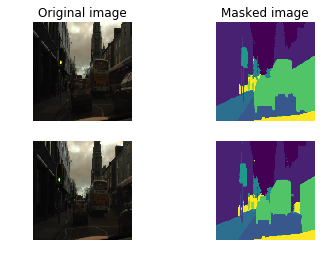

In [10]:
# plot sample images with their corresponding masks
plt.subplot(221)
plt.imshow(imgs[0])
plt.axis('off')
plt.title('Original image')
plt.grid('off')

plt.subplot(222)
plt.imshow(imgs_mask[0])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')

plt.subplot(223)
plt.imshow(imgs[1])
plt.axis('off')
plt.grid('off')

plt.subplot(224)
plt.imshow(imgs_mask[1])
plt.axis('off')
plt.grid('off')


In [11]:
# number of class labels for segmentation
num_classes = len(set(np.array(imgs_mask).flatten()))

In [12]:
# create segmentation array for each image
def createSegmentationArray(img):
    seg_labels = np.zeros((224, 224, 12))
    
    for c in range(12):
        seg_labels[:, :, c] = (img == c)
        
    seg_labels.astype(int)
    return seg_labels

In [13]:
# new list of image masks
imgs_mask_2 = []
for i in range(len(imgs_mask)):
    imgs_mask_2.append(createSegmentationArray(imgs_mask[i]))

In [14]:
imgs = np.array(imgs)
imgs_mask_2 = np.array(imgs_mask_2)

print("Images shape: {}".format(imgs.shape))
print("Image masks shape: {}".format(imgs_mask_2.shape))

Images shape: (367, 224, 224, 3)
Image masks shape: (367, 224, 224, 12)


In [15]:
# scale elements in each image from [0, 255] down to [0, 1] 
imgs = imgs/255

In [16]:
# define our model
base_pretrained_model = PTModel(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_pretrained_model.trainable = False
base_pretrained_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import Model

In [18]:
conv1 = Model(inputs=base_pretrained_model.input,outputs=base_pretrained_model.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_pretrained_model.input,outputs=base_pretrained_model.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_pretrained_model.input,outputs=base_pretrained_model.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_pretrained_model.input,outputs=base_pretrained_model.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_pretrained_model.input,outputs=base_pretrained_model.get_layer('block5_conv3').output).output
drop5 = Dropout(0.5)(conv5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
merge6 = concatenate([drop4,up6], axis=3)

conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = 3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(12, 1, activation='softmax')(conv9)

In [20]:
model = Model(input = base_pretrained_model.input, output = conv10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

C:\Users\peiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  """Entry point for launching an IPython kernel.


In [21]:
for layer in model.layers[:18]:
    layer.trainable = False

In [22]:
# compile the model
model.compile(optimizer=Adam(1e-3, decay=1e-6),
            loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
# fit the model and save the training process to history
history = model.fit(imgs, imgs_mask_2, epochs=15, batch_size=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 330 samples, validate on 37 samples
Epoch 1/15
330/330 [==============================] - 43s 129ms/step - loss: 0.8717 - acc: 0.7530 - val_loss: 0.8346 - val_acc: 0.7458
Epoch 2/15
330/330 [==============================] - 39s 117ms/step - loss: 0.6409 - acc: 0.8186 - val_loss: 0.8676 - val_acc: 0.7654
Epoch 3/15
330/330 [==============================] - 39s 117ms/step - loss: 0.5691 - acc: 0.8383 - val_loss: 0.9053 - val_acc: 0.7650
Epoch 4/15
330/330 [==============================] - 39s 117ms/step - loss: 0.5147 - acc: 0.8525 - val_loss: 0.7041 - val_acc: 0.7992
Epoch 5/15
330/330 [==============================] - 39s 117ms/step - loss: 0.4747 - acc: 0.8632 - val_loss: 0.6422 - val_acc: 0.8190
Epoch 6/15
330/330 [==============================] - 39s 117ms/step - loss: 0.4434 - acc: 0.8728 - val_loss: 0.7449 - val_acc: 0.8088
Epoch 7/15
330/330 

In [24]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

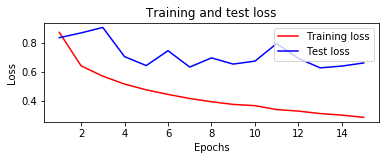

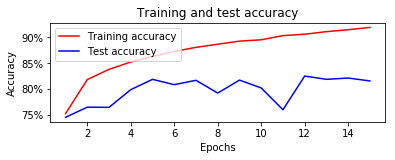

In [25]:
epochs = range(1, len(val_loss_values) + 1)
plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [27]:
# predictions
imgs_mask_pred = model.predict(imgs[-2:].reshape(2, 224, 224, 3))
imgs_mask_predi = np.argmax(imgs_mask_pred, axis=3)
imgs_mask_testi = np.argmax(imgs_mask_2[-2:].reshape(2, 224, 224, 12), axis=3)

In [28]:
# accuracy
np.mean(imgs_mask_predi == imgs_mask_testi)

0.8051359215561225

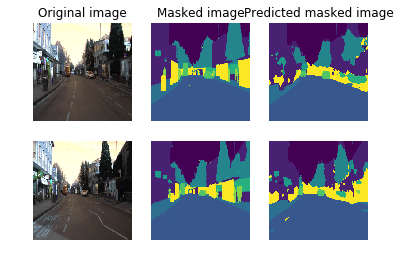

In [29]:
# evaluate performance of our model by observation
plt.subplot(231)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')

plt.subplot(232)
plt.imshow(imgs_mask[-1])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')

plt.subplot(233)
plt.imshow(imgs_mask_predi[-1])
plt.axis('off')
plt.title('Predicted masked image')
plt.grid('off')

plt.subplot(234)
plt.imshow(imgs[-2])
plt.axis('off')
plt.grid('off')

plt.subplot(235)
plt.imshow(imgs_mask[-2])
plt.axis('off')
plt.grid('off')

plt.subplot(236)
plt.imshow(imgs_mask_predi[-2])
plt.axis('off')
plt.grid('off')
plt.show()

In [ ]:
# visualize our model
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file="model.png")

from IPython.display import Image
Image(retina=True, filename="model.png")